In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [2]:
ylim = [0.0, 1.0]

In [3]:
import pandas as pd 

pd.set_option('display.max_columns', 30)

def get_noncoding_svs_windows(source):
    CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'
    # created using ${CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-noncoding-svs-with-windows.sh : 
    filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/{source}-noncoding-svs-chen-mchale.bed'
    df = pd.read_csv(filename, sep='\t')
    df['negative chen zscore'] = -df['chen_zscore']
    df = df[['sv_id', 'sv_length', 'alt_allele_count', 'N_bar', 'negative chen zscore']]
    df['sv is singleton'] = (df['alt_allele_count'] == 1) | (df['alt_allele_count'] == '1')  
    return df 

get_noncoding_svs_windows(source='gnomAD')

,sv_id,sv_length,alt_allele_count,N_bar,negative chen zscore,sv is singleton
0,gnomAD-SV_v2.1_DEL_1_142,991,7,-0.302927,-2.384293,False
1,gnomAD-SV_v2.1_DEL_1_149,147,1,2.411071,5.184148,True
2,gnomAD-SV_v2.1_DEL_1_159,535,1,4.229579,8.245072,True
3,gnomAD-SV_v2.1_DEL_1_159,535,1,6.525066,1.447034,True
4,gnomAD-SV_v2.1_DEL_1_160,706,6,4.339218,4.474465,False
...,...,...,...,...,...,...
290119,gnomAD-SV_v2.1_DEL_22_183690,5172,1,0.695360,3.189693,True
290120,gnomAD-SV_v2.1_DEL_22_183691,443,143,-0.097902,1.841140,False
290121,gnomAD-SV_v2.1_DEL_22_183698,107,2,-1.170174,0.357676,False
290122,gnomAD-SV_v2.1_DEL_22_183702,111,1,3.431271,4.115028,True


In [4]:
def aggregate_over_windows(source): 
    df = get_noncoding_svs_windows(source)
    groups = df.groupby(['sv_id', 'sv_length', 'alt_allele_count', 'sv is singleton'])
    aggregated = groups.agg({
        'N_bar': ['min'],
        'negative chen zscore': ['min']
    })
    df = aggregated.reset_index()
    df.columns = [' '.join(col[::-1]).strip() for col in df.columns.values]
    return df

aggregate_over_windows(source='gnomAD')

,sv_id,sv_length,alt_allele_count,sv is singleton,min N_bar,min negative chen zscore
0,gnomAD-SV_v2.1_DEL_10_107007,49197,4,False,3.982547,1.122394
1,gnomAD-SV_v2.1_DEL_10_107013,24139,2,False,3.982547,1.122394
2,gnomAD-SV_v2.1_DEL_10_107017,29252,2,False,3.677118,0.050239
3,gnomAD-SV_v2.1_DEL_10_107018,624,85,False,7.102004,7.344886
4,gnomAD-SV_v2.1_DEL_10_107019,9142,1,True,3.982547,0.050239
...,...,...,...,...,...,...
73048,gnomAD-SV_v2.1_DEL_9_99989,587,1,True,2.800996,-0.758455
73049,gnomAD-SV_v2.1_DEL_9_99990,590,1,True,2.800996,-0.758455
73050,gnomAD-SV_v2.1_DEL_9_99992,297,12,False,1.308338,-1.456946
73051,gnomAD-SV_v2.1_DEL_9_99997,1254,3,False,1.790784,0.695492


In [5]:
import numpy as np 

def label_svs_with_length_quantiles(source, number_length_quantiles): 
    df = aggregate_over_windows(source)
    df['sv length quantile'] = pd.qcut(
        df['sv_length'],
        q = number_length_quantiles, 
        labels = None, 
        retbins = False,
#         duplicates='drop'
    )
    return df
    
label_svs_with_length_quantiles(source='gnomAD', number_length_quantiles=10)

,sv_id,sv_length,alt_allele_count,sv is singleton,min N_bar,min negative chen zscore,sv length quantile
0,gnomAD-SV_v2.1_DEL_10_107007,49197,4,False,3.982547,1.122394,"(9917.8, 377037.0]"
1,gnomAD-SV_v2.1_DEL_10_107013,24139,2,False,3.982547,1.122394,"(9917.8, 377037.0]"
2,gnomAD-SV_v2.1_DEL_10_107017,29252,2,False,3.677118,0.050239,"(9917.8, 377037.0]"
3,gnomAD-SV_v2.1_DEL_10_107018,624,85,False,7.102004,7.344886,"(591.0, 857.0]"
4,gnomAD-SV_v2.1_DEL_10_107019,9142,1,True,3.982547,0.050239,"(5894.6, 9917.8]"
...,...,...,...,...,...,...,...
73048,gnomAD-SV_v2.1_DEL_9_99989,587,1,True,2.800996,-0.758455,"(350.0, 591.0]"
73049,gnomAD-SV_v2.1_DEL_9_99990,590,1,True,2.800996,-0.758455,"(350.0, 591.0]"
73050,gnomAD-SV_v2.1_DEL_9_99992,297,12,False,1.308338,-1.456946,"(169.0, 350.0]"
73051,gnomAD-SV_v2.1_DEL_9_99997,1254,3,False,1.790784,0.695492,"(857.0, 1461.0]"


In [6]:
def aggregate_over_length_quantiles(source, number_length_quantiles): 
    df = label_svs_with_length_quantiles(source, number_length_quantiles)    
    groups = df.groupby(['sv length quantile'])
    aggregated = groups.agg({
        'sv_length': ['mean', 'count'],
        'sv is singleton': ['mean', 'count']
    })
    df = aggregated.reset_index()
    return df

aggregate_over_length_quantiles(source='gnomAD', number_length_quantiles=10)

sv length quantile     sv_length       sv is singleton      
                               mean count            mean count
0     (99.999, 169.0]    127.960370  7343        0.551954  7343
1      (169.0, 350.0]    248.699204  7284        0.546266  7284
2      (350.0, 591.0]    472.844788  7319        0.512775  7319
3      (591.0, 857.0]    717.427769  7296        0.514391  7296
4     (857.0, 1461.0]   1119.017282  7291        0.502400  7291
5    (1461.0, 2501.0]   1947.225736  7305        0.506913  7305
6    (2501.0, 3911.0]   3181.105068  7300        0.554247  7300
7    (3911.0, 5894.6]   4837.709200  7304        0.553122  7304
8    (5894.6, 9917.8]   7574.091992  7305        0.540178  7305
9  (9917.8, 377037.0]  26703.418423  7306        0.573501  7306

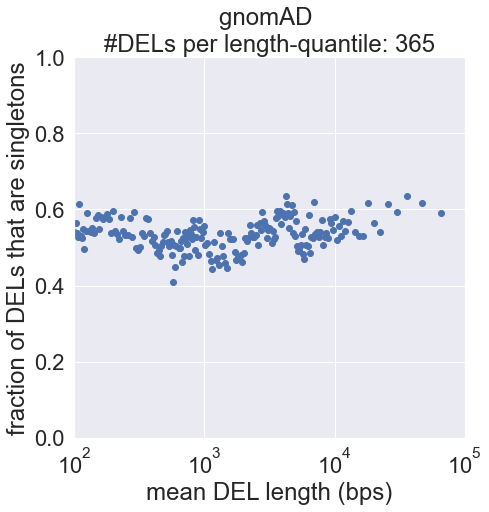

In [7]:
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (7, 7)

import seaborn as sns 
sns.set(font_scale = 2)

def plot_singleton_proportion_vs_sv_length_quantile(source, number_length_quantiles): 
    df = aggregate_over_length_quantiles(source, number_length_quantiles)
    plt.plot(df[('sv_length', 'mean')], df[('sv is singleton', 'mean')], 'o')
    plt.xscale('log')
    plt.ylim(ylim)
    plt.xlim([1e2, 1e5])
    plt.xticks([1e2, 1e3, 1e4, 1e5])
    plt.xlabel(f'mean DEL length (bps)')
    plt.ylabel(f'fraction of DELs that are singletons')
    mean_number_svs_per_length_quantile = int(np.mean(df[('sv_length', 'count')]))
    plt.title(f'{source} \n#DELs per length-quantile: {mean_number_svs_per_length_quantile}')
    
plot_singleton_proportion_vs_sv_length_quantile(source='gnomAD', number_length_quantiles=200)

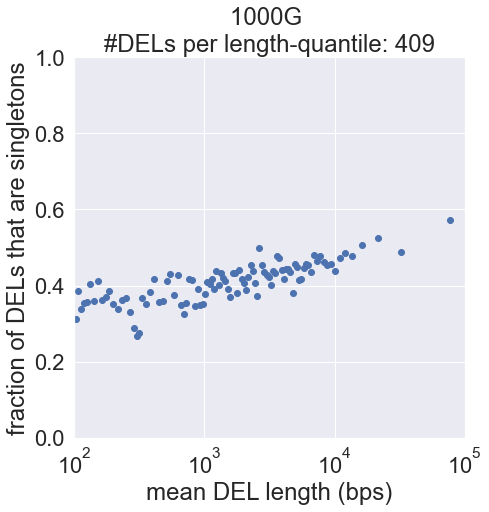

In [8]:
plot_singleton_proportion_vs_sv_length_quantile(source='1000G', number_length_quantiles=100)

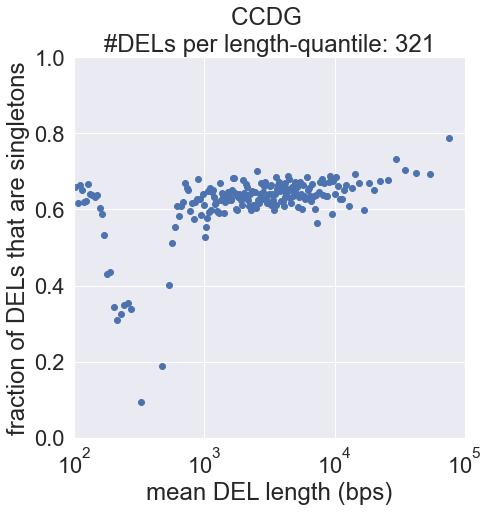

In [9]:
plot_singleton_proportion_vs_sv_length_quantile(source='CCDG', number_length_quantiles=200)

In [10]:
import warnings 

def label_svs_with_score_quantiles(source, score): 
    df = aggregate_over_windows(source)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")        

        array_of_quantiles = [0.00, 0.01, 0.02, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.98, 0.99, 1.00]
        starts = array_of_quantiles[:-1]
        ends = array_of_quantiles[1:]
        quantile_labels = [f'{start} - {end}' for start, end in zip(starts, ends)]

        df[f'min {score} quantile'], bins = pd.qcut(
            df[f'min {score}'],
            q = array_of_quantiles, 
            labels = quantile_labels, 
            retbins = True,
    #         duplicates='drop'
        )

        return df

label_svs_with_score_quantiles(source='gnomAD', score='N_bar')

,sv_id,sv_length,alt_allele_count,sv is singleton,min N_bar,min negative chen zscore,min N_bar quantile
0,gnomAD-SV_v2.1_DEL_10_107007,49197,4,False,3.982547,1.122394,0.9 - 0.95
1,gnomAD-SV_v2.1_DEL_10_107013,24139,2,False,3.982547,1.122394,0.9 - 0.95
2,gnomAD-SV_v2.1_DEL_10_107017,29252,2,False,3.677118,0.050239,0.9 - 0.95
3,gnomAD-SV_v2.1_DEL_10_107018,624,85,False,7.102004,7.344886,0.95 - 0.98
4,gnomAD-SV_v2.1_DEL_10_107019,9142,1,True,3.982547,0.050239,0.9 - 0.95
...,...,...,...,...,...,...,...
73048,gnomAD-SV_v2.1_DEL_9_99989,587,1,True,2.800996,-0.758455,0.9 - 0.95
73049,gnomAD-SV_v2.1_DEL_9_99990,590,1,True,2.800996,-0.758455,0.9 - 0.95
73050,gnomAD-SV_v2.1_DEL_9_99992,297,12,False,1.308338,-1.456946,0.75 - 0.9
73051,gnomAD-SV_v2.1_DEL_9_99997,1254,3,False,1.790784,0.695492,0.75 - 0.9


In [11]:
def aggregate_over_score_quantiles(source, score): 
    df = label_svs_with_score_quantiles(source, score)
    groups = df.groupby([f'min {score} quantile'])
    aggregated = groups.agg({
        'sv is singleton': ['mean', 'count']
    })
    df = aggregated.reset_index()
    return df

aggregate_over_score_quantiles(source='gnomAD', score='N_bar')

min N_bar quantile sv is singleton       
                                 mean  count
0          0.0 - 0.01        0.563611    731
1         0.01 - 0.02        0.571819    731
2         0.02 - 0.05        0.567777   2191
3          0.05 - 0.1        0.567753   3653
4          0.1 - 0.25        0.545538  10958
5          0.25 - 0.5        0.549058  18264
6          0.5 - 0.75        0.526065  18262
7          0.75 - 0.9        0.526239  10957
8          0.9 - 0.95        0.510539   3653
9         0.95 - 0.98        0.486536   2191
10        0.98 - 0.99        0.456908    731
11         0.99 - 1.0        0.456908    731

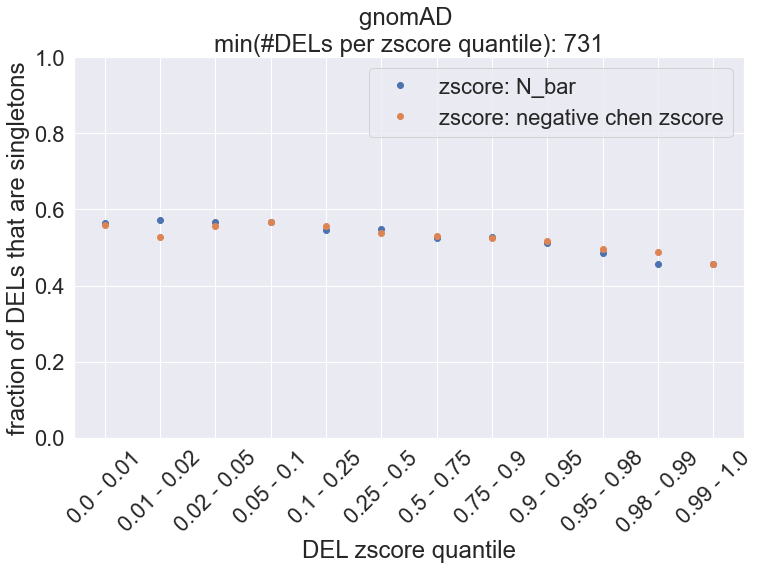

In [12]:
plt.rcParams["figure.figsize"] = (12, 7)

def plot_singleton_proportion_vs_score_quantile_core(source, score): 
    df = aggregate_over_score_quantiles(source, score)
    min_number_svs_per_zscore_quantile = int(np.min(df[('sv is singleton', 'count')]))    
    plt.plot(df[f'min {score} quantile'], df[('sv is singleton', 'mean')], 'o', label=f'zscore: {score}')
    return min_number_svs_per_zscore_quantile
    
def plot_singleton_proportion_vs_score_quantile(source): 
    min_number_svs_per_zscore_quantile = min(
        plot_singleton_proportion_vs_score_quantile_core(source, score='N_bar'),
        plot_singleton_proportion_vs_score_quantile_core(source, score='negative chen zscore')
    )
    plt.xlabel(f'DEL zscore quantile')
    plt.ylabel('fraction of DELs that are singletons')
    plt.xticks(rotation = 45)
    plt.ylim(ylim)
    plt.legend()
    plt.title(f'{source} \nmin(#DELs per zscore quantile): {min_number_svs_per_zscore_quantile}')
    
plot_singleton_proportion_vs_score_quantile(source='gnomAD')

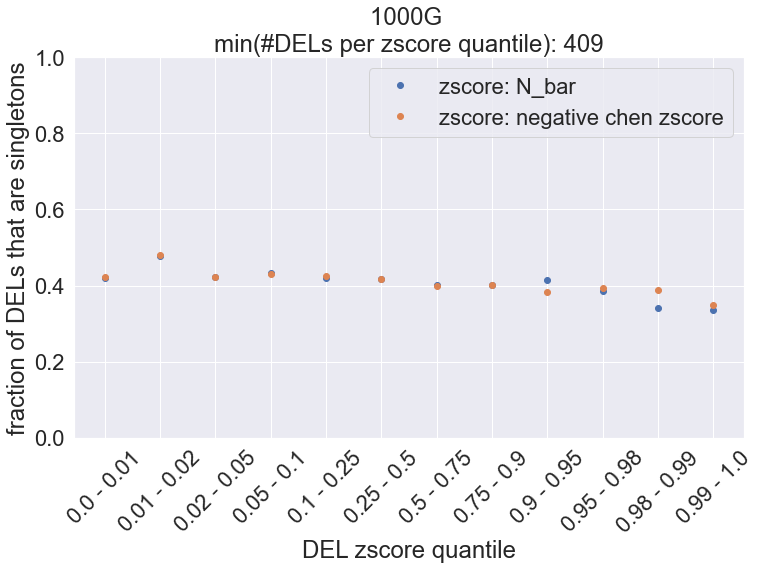

In [13]:
plot_singleton_proportion_vs_score_quantile(source='1000G')

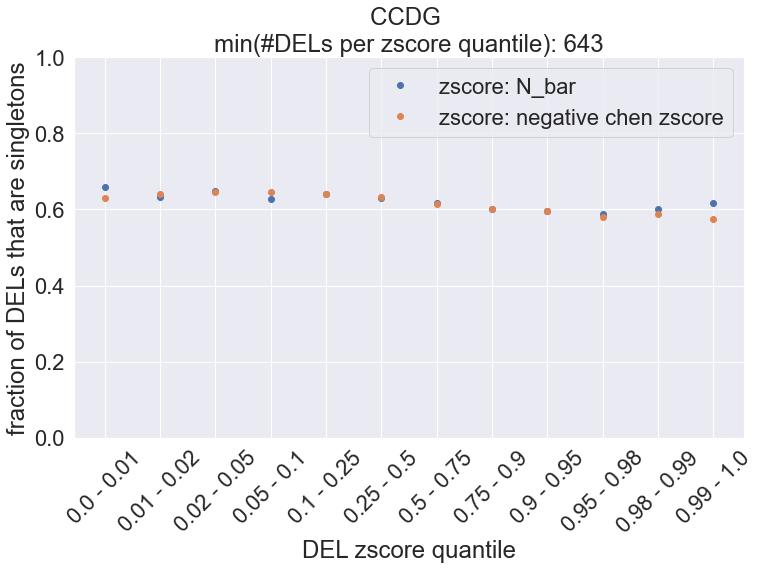

In [14]:
plot_singleton_proportion_vs_score_quantile(source='CCDG')

In [15]:
# TODO: correct for sv lengths using the APS metric: 

# 3. assign "mean singleton classification" to each SV in data frame, or fit a curve, and assign the fitted curve to each sv 
# 4. Group SVs by zscore and aggregate (sum of estimated singleton probabilities, sum of observed singleton classifications)
# 5. subtract to get APS for each group, and plot APS as a function of zscore quantiles 
